In [2]:
#Dependencies
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Importing packeges to retrive data from  spark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pathlib import Path
import time
import findspark
findspark.init()

In [4]:
%env SPARK_LOCAL_HOSTNAME=localhost
# Initialize Spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()
#Define Path 
data0 = Path('Resources/movies_dataset_0.csv').resolve()
data1 = Path('Resources/movies_dataset_1.csv').resolve()
data2 = Path('Resources/movies_dataset_2.csv').resolve()
data3 = Path('Resources/movies_dataset_3.csv').resolve()

# Read the CSV file using the absolute path
df0 = spark.read.csv(
    str(data0), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    # Handles quoted strings
    escape='"',   # Escape character for embedded quotes
    multiLine=True  # Handles multiline fields in case of long text
)

df1 = spark.read.csv(
    str(data1), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    
    escape='"',   
    multiLine=True  
)
df2 = spark.read.csv(
    str(data2), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    
    escape='"',   
    multiLine=True  
)
df3 = spark.read.csv(
    str(data3), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    
    escape='"',   
    multiLine=True  
)
# #Merge the Dataframes using union
merged_df = df0.union(df1).union(df2).union(df3)
merged_df.show()

env: SPARK_LOCAL_HOSTNAME=localhost
+----------+--------------------+-------+--------------------+---------+----------+----------+-----------+----------------------+-----------------+---------+----------+-----------------+-------------------+--------------------+--------------------+---------+----------+----------+------------------+--------------------+------------+-------+
|   imdb_id|               title|runtime|            overview|    rated|imdb_votes|popularity|imdb_rating|rotten_tomatoes_rating|metacritic_rating|   budget|   revenue|financial_success|             star_1|              star_2|              star_3|  genre_1|   genre_2|   genre_3|        director_1|          director_2|release_year|outcome|
+----------+--------------------+-------+--------------------+---------+----------+----------+-----------+----------------------+-----------------+---------+----------+-----------------+-------------------+--------------------+--------------------+---------+----------+----------+

In [5]:
# Create our temporary view
merged_df.createOrReplaceTempView('movies')

In [6]:
#
spark.sql("""
SELECT star_1,
       count(*) AS number_of_stars
FROM movies
GROUP BY star_1
ORDER BY number_of_stars DESC
""").show(20)

+--------------------+---------------+
|              star_1|number_of_stars|
+--------------------+---------------+
|           Tom Hanks|             23|
|        Adam Sandler|             23|
|          Tom Cruise|             22|
|       Mark Wahlberg|             21|
|  Sylvester Stallone|             21|
|        Nicolas Cage|             20|
|        Keanu Reeves|             19|
|      Dwayne Johnson|             18|
|Arnold Schwarzene...|             17|
|         Johnny Depp|             17|
|   Denzel Washington|             16|
|        Bruce Willis|             16|
|          Will Smith|             16|
|   Leonardo DiCaprio|             15|
|          Jim Carrey|             15|
|         Ben Affleck|             14|
|       Ryan Reynolds|             13|
|      Robert De Niro|             13|
|           Brad Pitt|             13|
|     Jake Gyllenhaal|             12|
+--------------------+---------------+
only showing top 20 rows



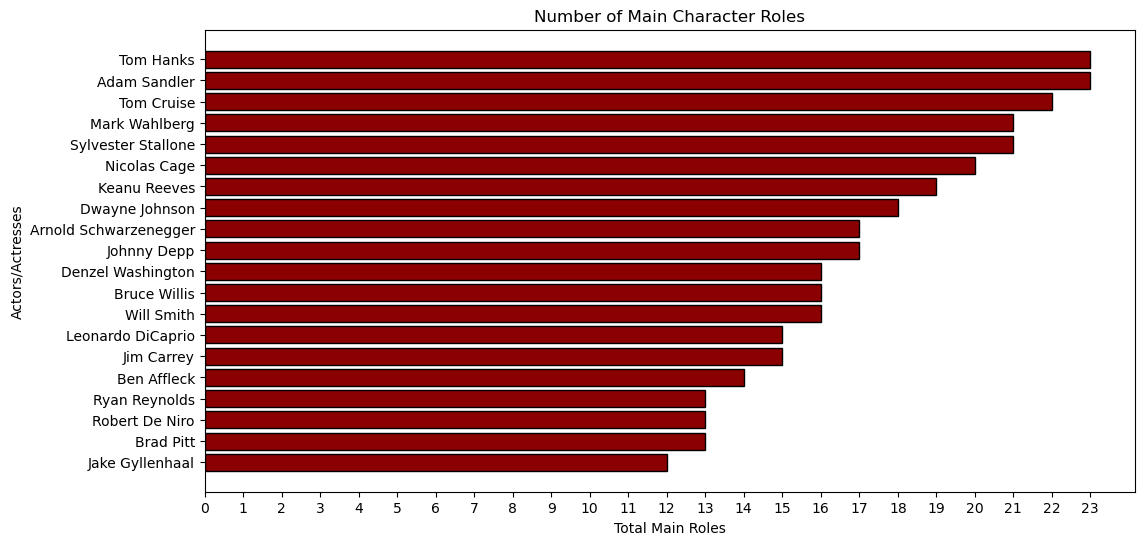

In [7]:
# Bar Graph for the top 20 actors and their main star counts

actors = [
    "Tom Hanks", "Adam Sandler", "Tom Cruise", "Mark Wahlberg",
    "Sylvester Stallone", "Nicolas Cage", "Keanu Reeves", 
    "Dwayne Johnson", "Arnold Schwarzenegger", "Johnny Depp",
    "Denzel Washington", "Bruce Willis", "Will Smith", 
    "Leonardo DiCaprio", "Jim Carrey", "Ben Affleck", 
    "Ryan Reynolds", "Robert De Niro", "Brad Pitt", 
    "Jake Gyllenhaal"
]
total_stars = [
    23, 23, 22, 21, 21, 20, 19, 18, 
    17, 17, 16, 16, 16, 15, 15, 14, 
    13, 13, 13, 12
]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.barh(actors, total_stars, color='darkred', edgecolor='black')
plt.xlabel('Total Main Roles')
plt.ylabel('Actors/Actresses')
plt.title('Number of Main Character Roles')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest stars on top
# plt.cm.plasma
# Add more tick marks
max_stars = max(total_stars)
plt.xticks(np.arange(0, max_stars + 1, 1))
plt.show()

In [8]:
#Movies with finantial success
spark.sql("""
SELECT title, revenue, budget
FROM movies
WHERE financial_success = true
ORDER BY  revenue  DESC   
""").show(truncate=False)

+------------------------------+----------+---------+
|title                         |revenue   |budget   |
+------------------------------+----------+---------+
|Avatar                        |2923706026|237000000|
|Avengers: Endgame             |2799439100|356000000|
|Avatar: The Way of Water      |2320250281|460000000|
|Titanic                       |2264162353|200000000|
|Avengers: Infinity War        |2052415039|300000000|
|Spider-Man: No Way Home       |1921847111|200000000|
|Jurassic World                |1671537444|150000000|
|The Lion King                 |1663000000|260000000|
|The Avengers                  |1518815515|220000000|
|Furious 7                     |1515400000|190000000|
|Top Gun: Maverick             |1488732821|170000000|
|Frozen II                     |1453683476|150000000|
|Barbie                        |1445638421|145000000|
|Avengers: Age of Ultron       |1405403694|365000000|
|The Super Mario Bros. Movie   |1362000000|100000000|
|Black Panther              

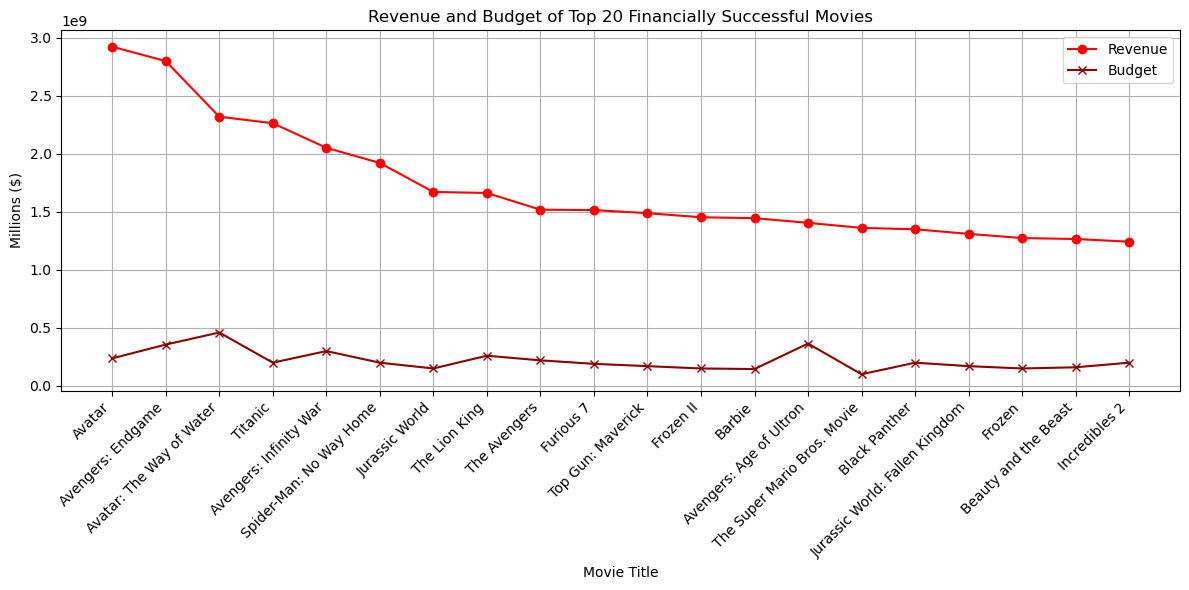

In [10]:
#Line graph for the top 20 successful movies in regards to revenue

data = {
    "title": [
        "Avatar", "Avengers: Endgame", "Avatar: The Way of Water", "Titanic",
        "Avengers: Infinity War", "Spider-Man: No Way Home", "Jurassic World",
        "The Lion King", "The Avengers", "Furious 7", "Top Gun: Maverick",
        "Frozen II", "Barbie", "Avengers: Age of Ultron", "The Super Mario Bros. Movie",
        "Black Panther", "Jurassic World: Fallen Kingdom", "Frozen",
        "Beauty and the Beast", "Incredibles 2"
    ],
    "revenue": [
        2923706026, 2799439100, 2320250281, 2264162353,
        2052415039, 1921847111, 1671537444, 1663000000,
        1518815515, 1515400000, 1488732821, 1453683476,
        1445638421, 1405403694, 1362000000, 1349926083,
        1310466296, 1274219009, 1266115964, 1242805359
    ],
    "budget": [
        237000000, 356000000, 460000000, 200000000,
        300000000, 200000000, 150000000, 260000000,
        220000000, 190000000, 170000000, 150000000,
        145000000, 365000000, 100000000, 200000000,
        170000000, 150000000, 160000000, 200000000
    ]
}

# Create a Pandas DataFrame directly from the dictionary
pandas_df = pd.DataFrame(data)

# The line graph with movie titles rotated for better visibility
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['title'], pandas_df['revenue'], marker='o', label='Revenue', color='r')
plt.plot(pandas_df['title'], pandas_df['budget'], marker='x', label='Budget', color='darkred')

plt.title('Revenue and Budget of Top 20 Financially Successful Movies')
plt.xlabel('Movie Title')
plt.ylabel('Millions ($)')
plt.xticks(rotation=45, ha='right') 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()